In [29]:
from os import sys
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter

In [30]:
df = main.get_data("Alton", "/linus-2023-05-18/00000009.BIN", "10ms")
df = df.interpolate(method="linear")

Recording    - INFO     - Loading recording file using reader: ArdupilotDFReader and processor: AP433Dataflash
ArdupilotDFReader - INFO     - Begin processing /Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/data//linus-2023-05-18/00000009.BIN
ArdupilotDFReader - INFO     - GPS time found on channel=GPS, instance=1
ArdupilotDFReader - INFO     - 2023-05-19 02:24:52.400000 at board time = 1970-01-01 00:01:45.346194


In [31]:
# Vehicle parameters
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 2 # Estimated with virtual bolt included
span = 2.54
chord = 0.2
linus = airplane(mass, chord, span)

P_systems = 0.3 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True
print(linus.area)

0.508


# Need to Do for Power Estimate
1. Rotate the accelerations into the body frame (Find $\dot{U}$)
2. Estimate the propeller thrust $T$
3. Establish the variance of the measurement
4. Bin the results by airspeed!

$ P_{req} = T V_T - mg\dot{h} - m \dot{U} V_T $

# Generating Plots (Acceleration Visualization)

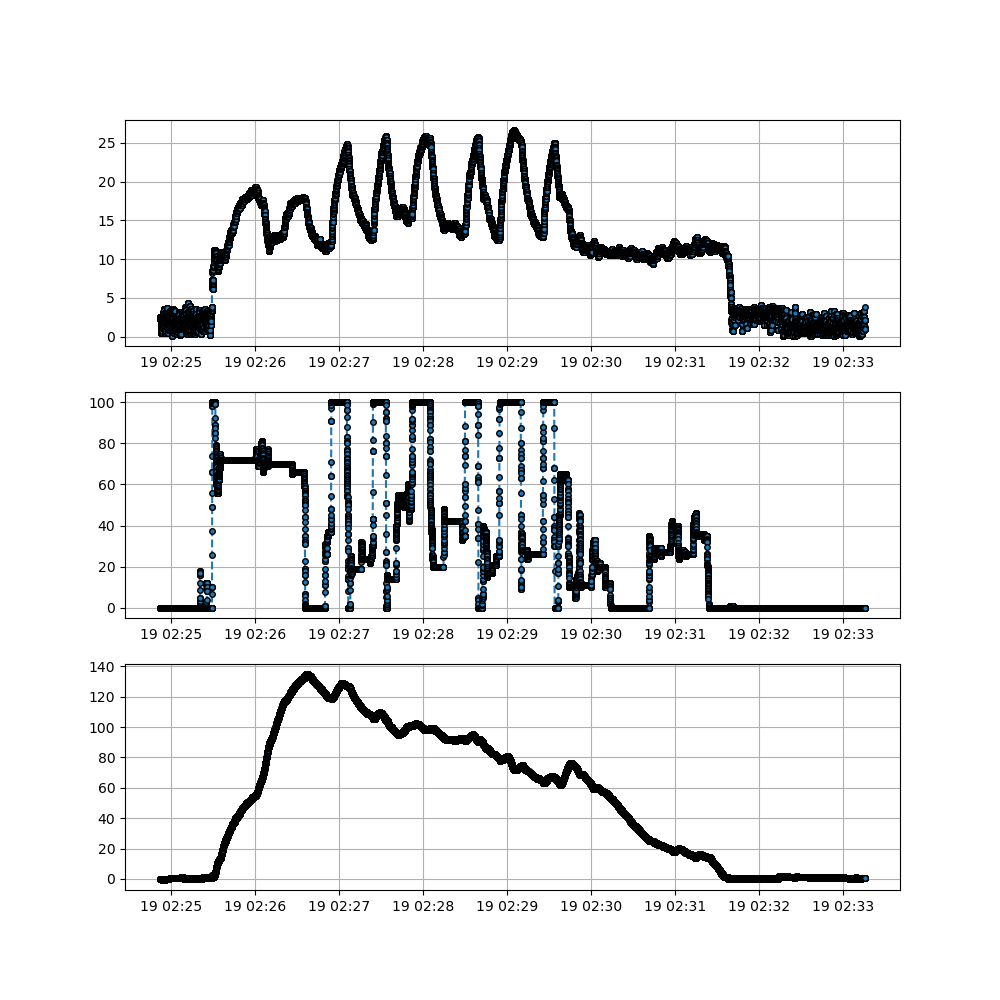

In [32]:
# Generating Plots

plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

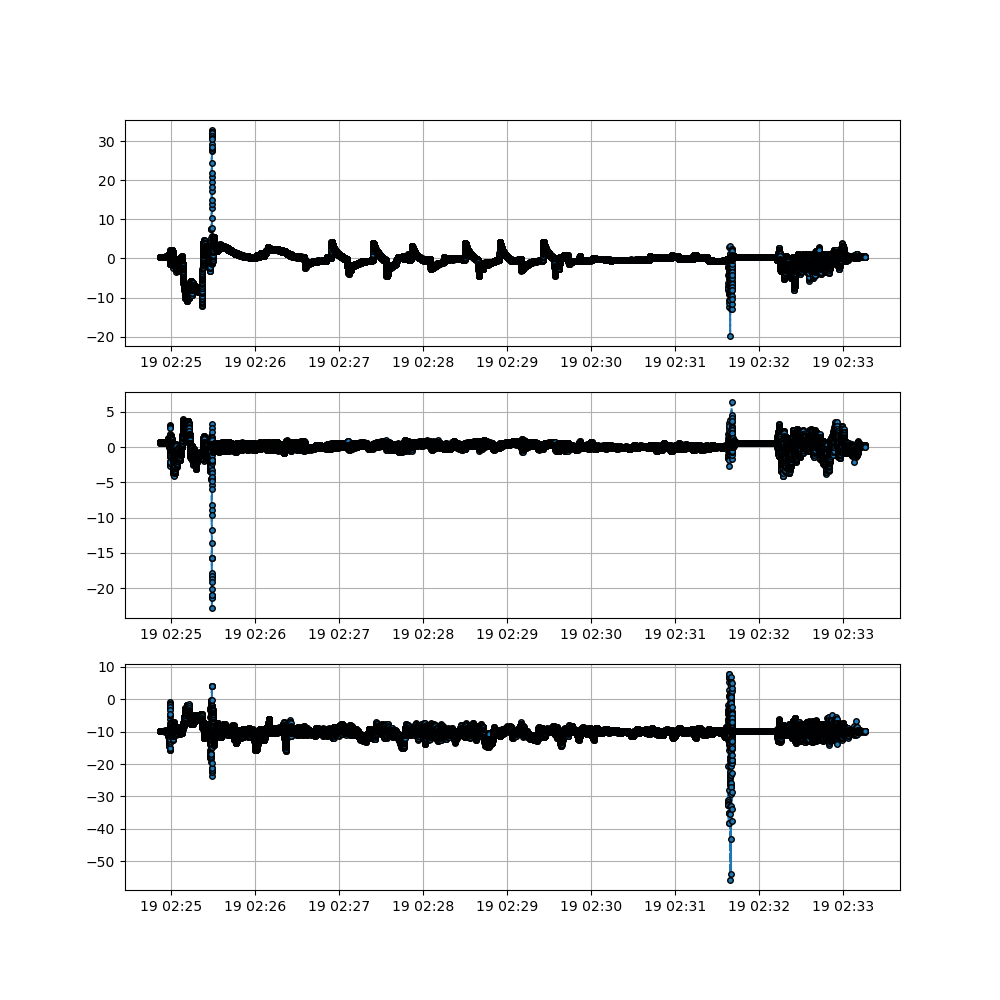

In [33]:
plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.XAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.YAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ZAcc_IMU0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

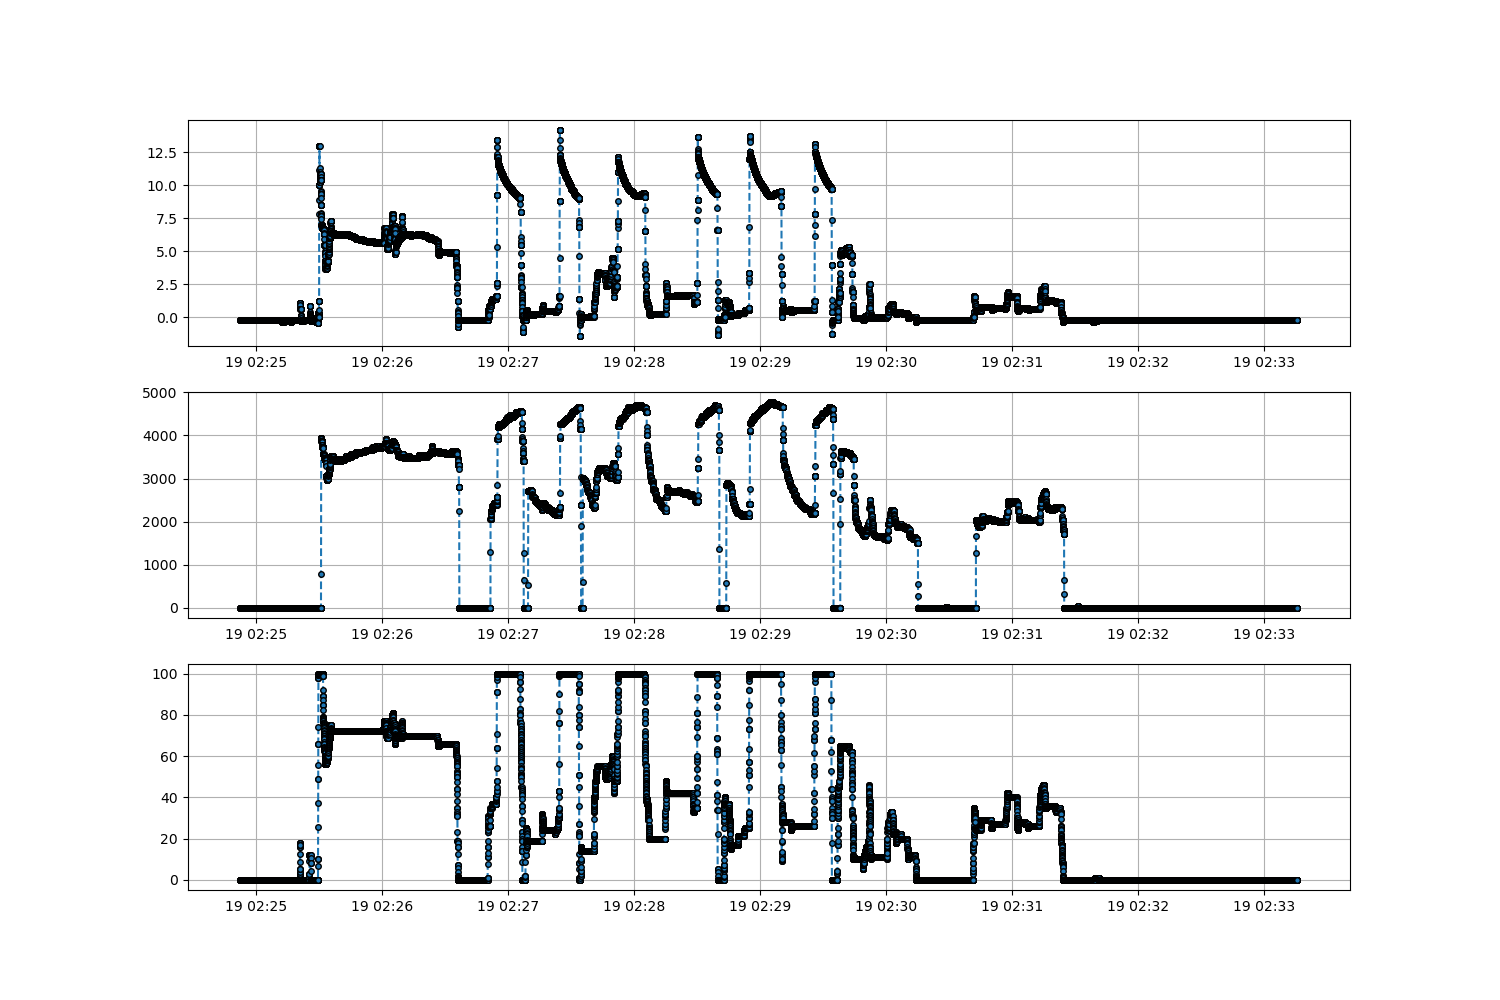

In [34]:
# Generating Plots

plt.figure(figsize=(15,10))
plt.tight_layout()

ax0 = plt.subplot(3,1,1)
plt.grid("On")
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])

ax0 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
ax0.plot(df.index, df.MotorRPM, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])

ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.grid("On")
plt.show()

In [35]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing masks for dataframe

def get_mask(df, start, end, year, month, day):
    # Getting boolean mask from start and end times
    start_time = get_datetime(start, year, month, day)
    end_time = get_datetime(end, year, month, day)
    mask = (df.index > start_time) & (df.index < end_time)
    return mask

def get_datetime(hour_string, year, month, day):
    # Results completed datetime from hour string, and date
    split_nums = hour_string.split(':')
    hours = int(split_nums[0])
    minutes = int(split_nums[1])
    seconds = int(split_nums[2])
    return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2023
month = 5
day = 19

# Cruise Masking

seg_times = np.array([['02:26:55','02:27:05'],
                      ['02:27:25','02:27:33'],
                      ['02:27:53','02:28:05'],
                      ['02:28:31','02:28:39'],
                      ['02:28:56','02:29:10'],
                      ['02:29:27','02:29:33']])
# seg_times = np.array([['02:26:54.55','02:27:05.65'],
#                       ['02:27:24.32','02:27:33.49']])
masks = []
for i in range(np.shape(seg_times)[0]):
    mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    masks.append(mask)

In [36]:
############# Main Analysis ###############3

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Propulsion characterization
ni = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
n = ni * (0.1428571429/0.083333333)                                                        # Bad RPM compensation (Pole miscount?)
i_esc = df["MainBatteryCurrent"].to_numpy()                      # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df["XAcc_IMU0"].to_numpy()                       # Acceleration in X direction of the IMU
zp_acc = df["ZAcc_IMU0"].to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - 9.807 * np.sin(theta)
W_dot = zp_acc + 9.807 * np.cos(theta) * np.cos(phi)

# Beginning Power Required Calculation #

CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4
P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dot * v_tas)
P_req = P_req_t1 + P_req_t2 + P_req_t3
D = P_req / v_tas

CD = D / (0.5 * rho * v_tas**2 * linus.area) # still need to estimate the wing area of linus
CL = (linus.weight - (linus.mass*W_dot)) / (0.5 * rho * v_tas**2 * linus.area)

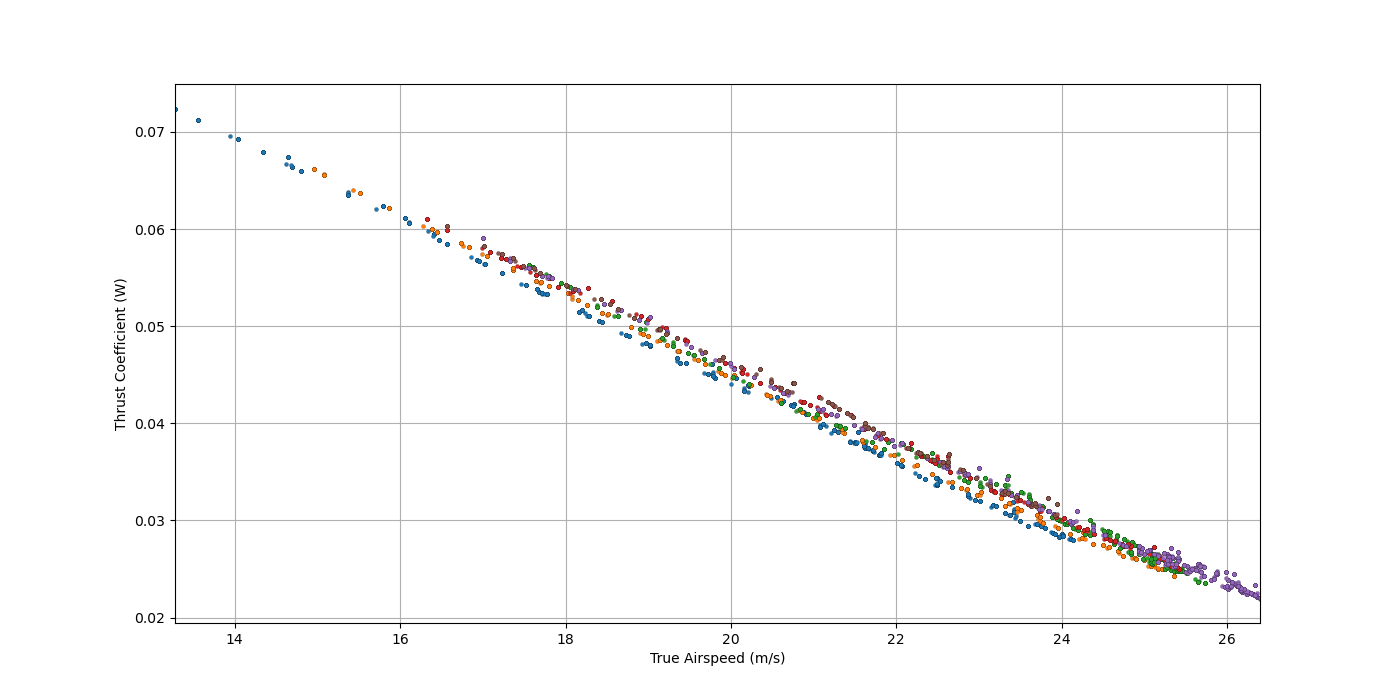

In [37]:
markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,1,1)
for i in range(len(masks)):
    ax1.plot(v_tas[masks[i]], CT[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Thrust Coefficient (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)
plt.show()

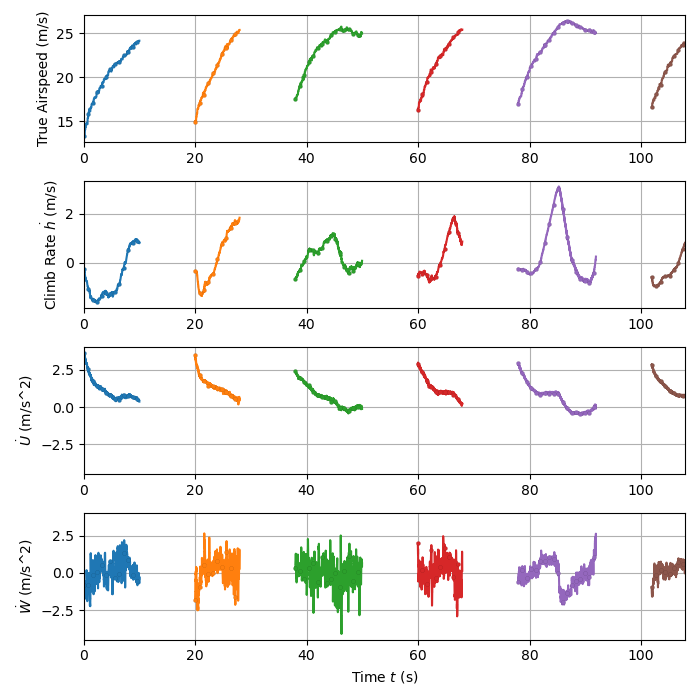

In [38]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, Vd_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Climb Rate $\dot{h}$ (m/s)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, U_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$\dot{U}$ (m/s^2)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, W_dot[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\dot{W}$ (m/s^2)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

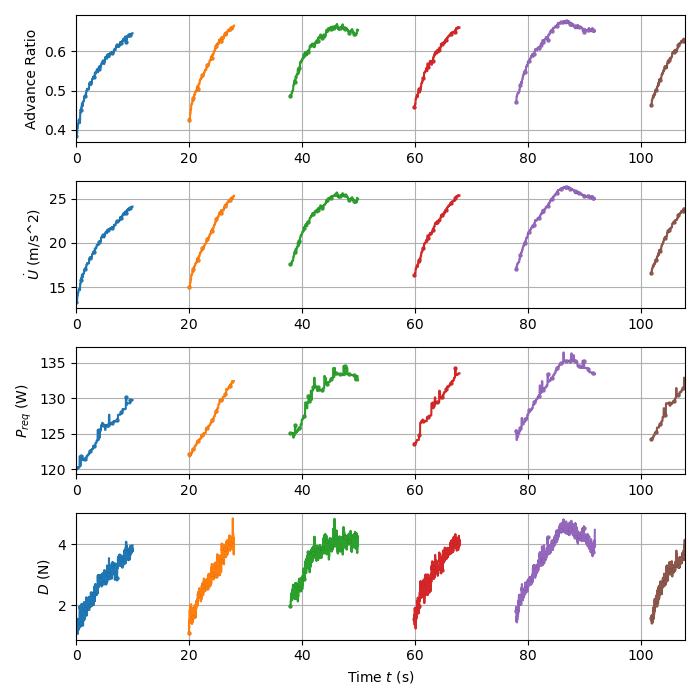

In [39]:
# Plotting Acceleration Runs
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, J[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("Advance Ratio")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("$\dot{U}$ (m/s^2)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, n[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$P_{req}$ (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, D[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$D$ (N)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()

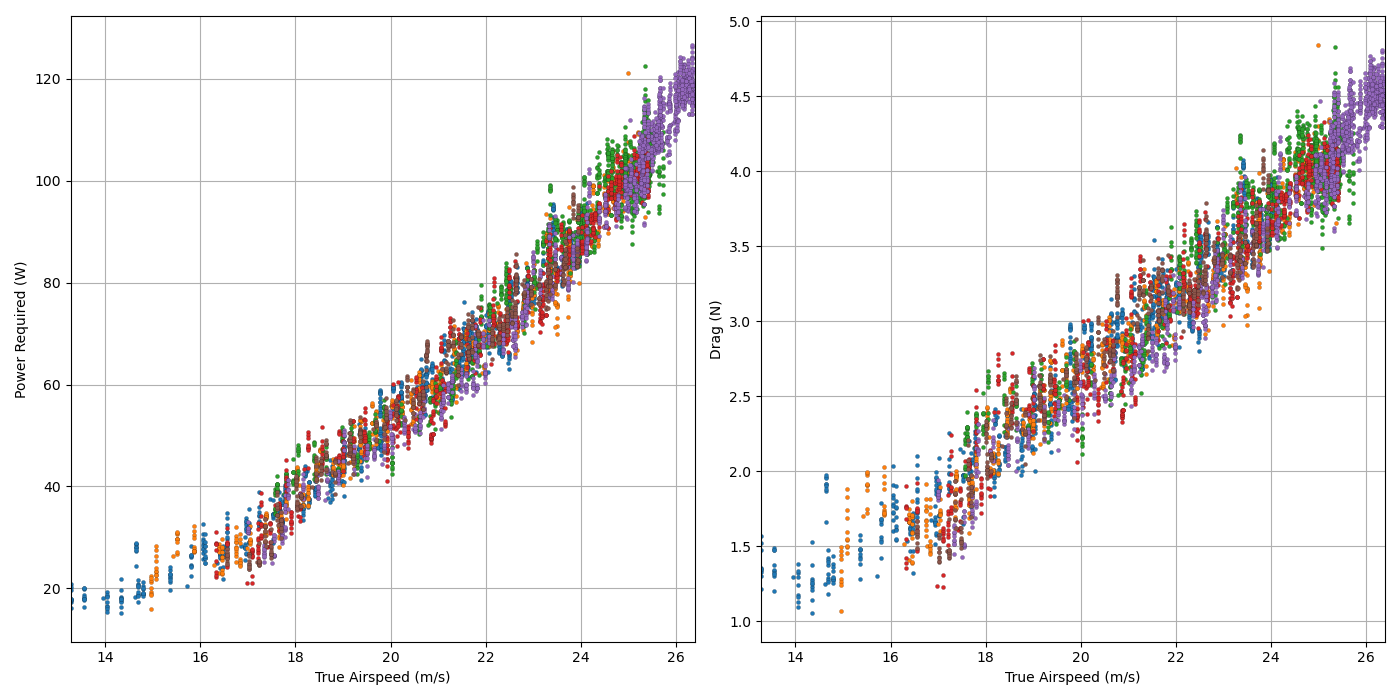

In [40]:
# Overplotting the results of the 6 Accelerations #

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,2,1)
for i in range(len(masks)):
    ax1.plot(v_tas[masks[i]], P_req[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Power Required (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(1,2,2)
for i in range(len(masks)):
    ax2.plot(v_tas[masks[i]], D[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Drag (N)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

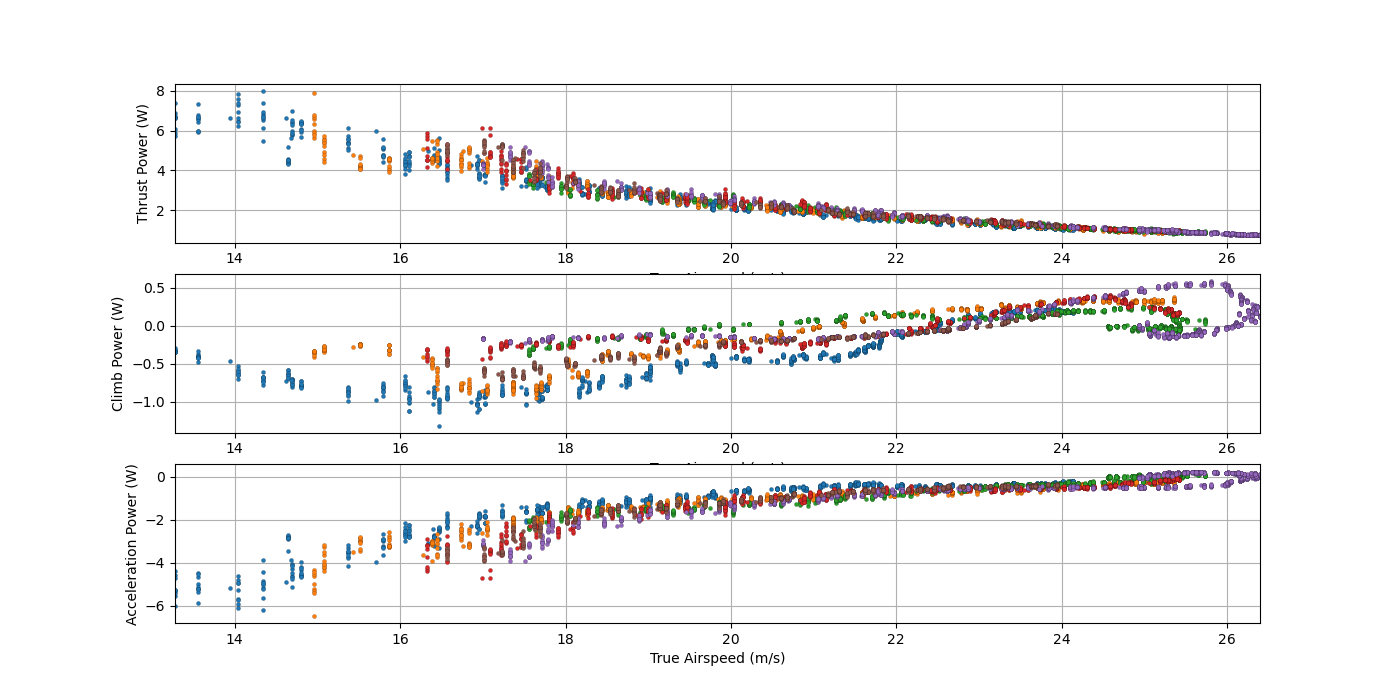

In [41]:
# Plotting all terms of power required to see significance

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(3,1,1)
for i in range(len(masks)):
    ax1.plot(v_tas[masks[i]], P_req_t1[masks[i]]/P_req[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Thrust Power (W)")
ax1.set_xlabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(3,1,2)
for i in range(len(masks)):
    ax2.plot(v_tas[masks[i]], P_req_t2[masks[i]]/P_req[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Climb Power (W)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(3,1,3)
for i in range(len(masks)):
    ax3.plot(v_tas[masks[i]], P_req_t3[masks[i]]/P_req[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax3.set_ylabel("Acceleration Power (W)")
ax3.set_xlabel("True Airspeed (m/s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

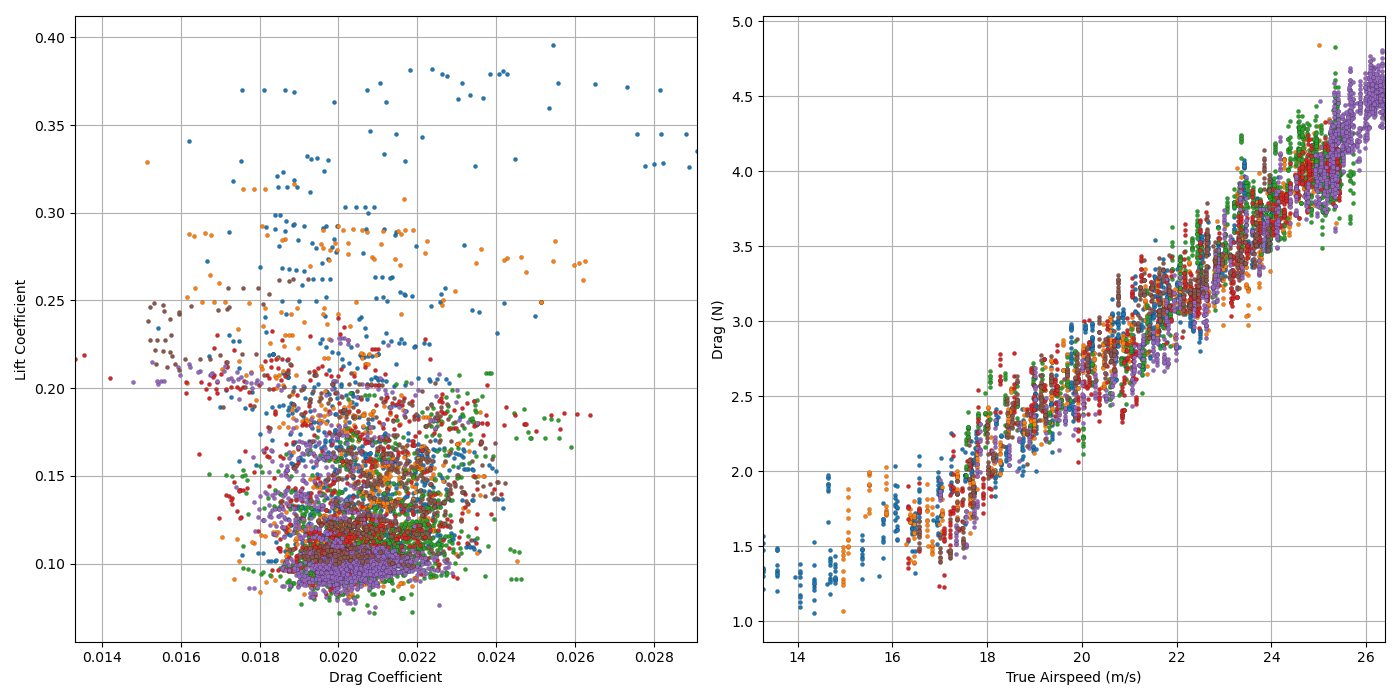

In [42]:
# Plotting the drag polar of the Vehicle

markerstyle = 'o'
markerevery = 1
markedgew = 0.1
plt.figure(figsize=(14,7))
ax1 = plt.subplot(1,2,1)
for i in range(len(masks)):
    ax1.plot(CD[masks[i]], CL[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax1.set_ylabel("Lift Coefficient")
ax1.set_xlabel("Drag Coefficient")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(1,2,2)
for i in range(len(masks)):
    ax2.plot(v_tas[masks[i]], D[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, linestyle='')
ax2.set_ylabel("Drag (N)")
ax2.set_xlabel("True Airspeed (m/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
plt.show()

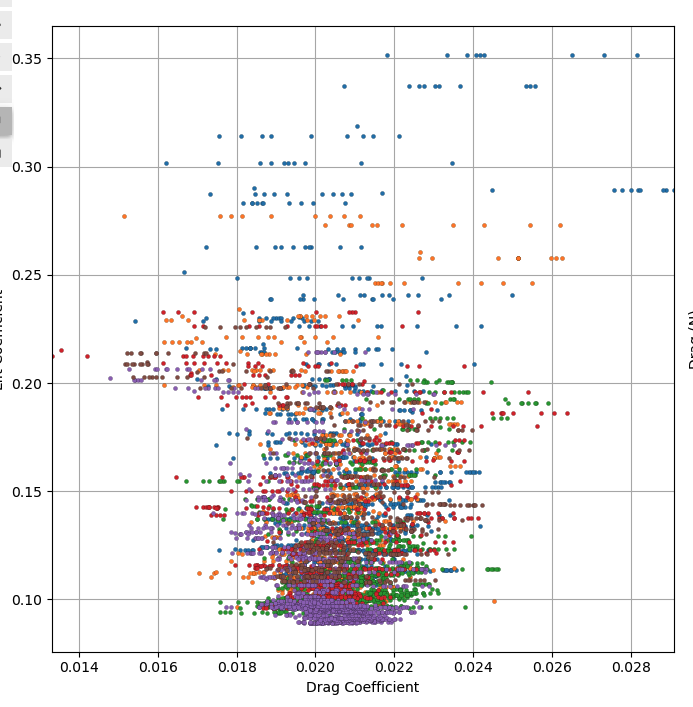
Image above with CL calculated based on the weight alone.  

# Small Conclusions

There is something going on with my propeller model, since $C_T$ appears to be negative at some points.  This means the power required goes negative. Surprisingly promising results off the bat in terms of the variation of power required measurement and the drag estimation.  Lets keep going, but with data from UIUC on the Aeronaut 11x7.  

So the UIUC Data shows the CT as a function of J, but the $C_T$ goes negative at an advance ratio of around 0.8.  When looking at the data for the accelerations, you can see the J jump past 0.8 into the region where it should be negative and contribute to the drag.  

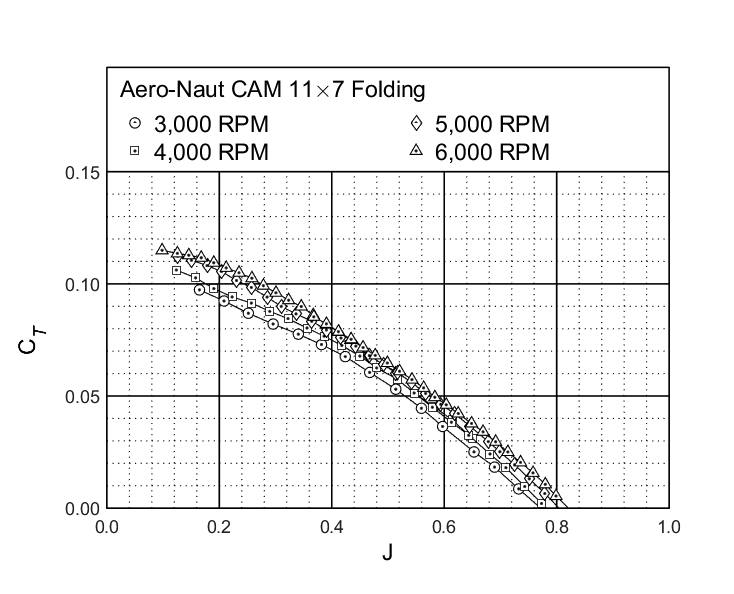

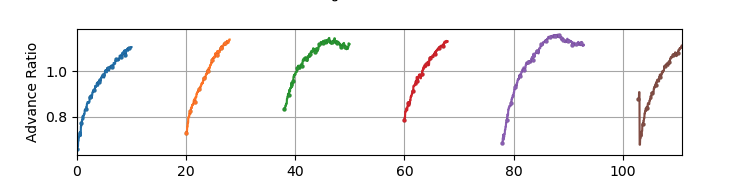

This means there must be something wrong with either the airspeed measurement, which seems unlikely because of the calibration process, or the motor RPM.  The motor RPM is being measured using an inexpensive HobbyZone sensor, that needs to be configured correctly in ArduPlane to work correctly.  I suspect that the parameter of the number of motor poles is incorrect, or at least inaccurate.  For now, I will scale the RPM up by some factor until the $C_T$ is again completely positive.  

Calibration of the RPM sensor must be done using the optical RPM sensor.  
Done!

# Lua Scripting Goals:

It looks like the blue and orange accelerations were the best for the low range, because they started at lower airspeeds.  Its possible more of the other acceleration data would be useable for ramped throttle instead of a sudden jump. The throttle ramp might also be the ticket to get pitch controller to compensate for altitude gain quick enough.  

function update () -- periodic function that will be called
  local current_pos = ahrs:get_position() -- fetch the current position of the vehicle
  local home = ahrs:get_home()            -- fetch the home position of the vehicle
  if current_pos and home then            -- check that both a vehicle location, and home location are available
    local distance = current_pos:get_distance(home) -- calculate the distance from home in meters
    if distance > 1000 then -- if more then 1000 meters away
      distance = 1000;      -- clamp the distance to 1000 meters
    end
    servo.set_output_pwm(96, 1000 + distance) -- set the servo assigned function 96 (scripting3) to a proportional value
  end

  return update, 1000 -- request "update" to be rerun again 1000 milliseconds (1 second) from now
end

return update, 1000   -- request "update" to be the first time 1000 milliseconds (1 second) after script is loaded

Servo Channels (SRV_Channels:)

set_output_pwm_chan_timeout(channel, pwm, timeout) - Sets servo channel to specified PWM for a time in ms. This overrides any commands from the autopilot until the timeout expires.

Servo Output

This method stands alone and is called directly as shown below.

servo.set_output (function_number, PWM) - Sets servo outputs of type function_number to a PWM value (typically between 1000 and 2000)

